In [1]:
#import library
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
sns.set_style('darkgrid')
import warnings

warnings.filterwarnings("ignore")
from transformers import pipeline
import finnhub
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax


In [21]:
stock_data = yf.download('AAPL',start='2024-1-1',end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [22]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553467,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222336,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495071,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500


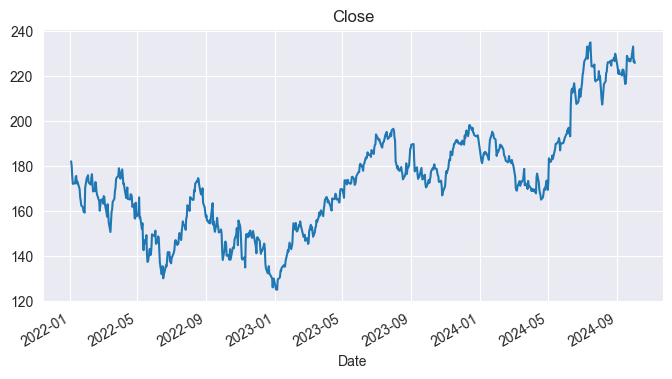

In [42]:
# @title Close

from matplotlib import pyplot as plt
stock_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
finnhub_client = finnhub.Client(api_key="cnl0n1pr01qjvabn3kngcnl0n1pr01qjvabn3ko0")

news = pd.DataFrame(finnhub_client.company_news('AAPL', _from="2024-10-01", to='2024-10-10'))

#.drop(columns=['id','image','category'])

news1 = pd.DataFrame(finnhub_client.company_news('AAPL', _from="2023-01-06", to='2024-01-01')).drop(columns=['id','image','category'])
news['datetime'] = pd.to_datetime(news['datetime'], unit='s').dt.strftime('%Y-%m-%d')
news['datetime'] = pd.to_datetime(news['datetime'])
print("df shape: ", news.shape)
print("First row date: ", news.iloc[0]['datetime'])
print("Last row date: ", news.iloc[-1]['datetime'])

sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def safe_sentiment(text):
    try:
        return sentiment_pipeline(text)[0]
    except Exception as e:
        print(f"Error processing text: {e}")
        # Optionally, return neutral/default sentiment
        return {'label': 'NEUTRAL', 'score': 0}
    
#shorten_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")

a = news['summary'].apply(lambda x: safe_sentiment(x))
a.head()




df shape:  (222, 9)
First row date:  2024-10-10 00:00:00
Last row date:  2024-10-07 00:00:00


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


Error processing text: The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1


0    {'label': 'neutral', 'score': 0.9334975481033325}
1    {'label': 'negative', 'score': 0.5668959021568...
2    {'label': 'neutral', 'score': 0.8791483044624329}
3    {'label': 'neutral', 'score': 0.8992360234260559}
4    {'label': 'negative', 'score': 0.8896549344062...
Name: summary, dtype: object

In [ ]:
import time


finnhub_client = finnhub.Client(api_key="cnl0n1pr01qjvabn3kngcnl0n1pr01qjvabn3ko0")

# Set the date range - 1 year free range
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# DataFrame to store all news
all_news = pd.DataFrame()

# Loop over the date range in steps of 5 days
current_date = start_date
while current_date < end_date:
    _to = current_date + timedelta(days=5)
    if _to > end_date:
        _to = end_date

    # Fetch the news
    news_data = pd.DataFrame(finnhub_client.company_news('AAPL', _from=current_date.strftime('%Y-%m-%d'), to=_to.strftime('%Y-%m-%d')))
    if not news_data.empty:
        news_data = news_data.drop(columns=['id', 'image', 'category'])
        news_data['datetime'] = pd.to_datetime(news_data['datetime'], unit='s').dt.strftime('%Y-%m-%d')
        all_news = pd.concat([news_data.iloc[::-1], all_news], ignore_index=True)
    
    # Update the current date
    current_date = _to

    #sleep to avoid reaching limit
    time.sleep(1)

# Save the DataFrame to a CSV file
all_news.to_csv('./AAPL_news.csv', index=False)

In [44]:
news.loc[217]

datetime                                  2023-12-27 00:00:00
headline        Meta Platforms: Potential $500 Target In 2024
related                                                  AAPL
source                                           SeekingAlpha
summary     Meta Platforms has experienced a significant r...
url         https://finnhub.io/api/news?id=3a1ee352637478c...
Name: 217, dtype: object

In [45]:
news.loc[0,'summary']

'Legendary investor Warren Buffett has long preached the importance of passive investing in large-cap stocks. "Beware the investment activity that produces applause; the great moves are usually greeted by yawns," said Buffett, who also is a big fan of dividend-yielding stocks, which he calls the secret sauce to Berkshire Hathaway Inc.\'s success. Nearly 75% of Buffett\'s portfolio is invested in just five stocks. Take a closer look. Apple Buffett has been a long-time supporter of Apple Inc. (NASDAQ'

In [46]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)
    sentiment_index = probs.argmax().item()
    label_mapping = {0: -1, 1: 0, 2: 1}
    return label_mapping[sentiment_index]

In [47]:
news['sentiment'] = news['headline'].apply(predict_sentiment)

In [48]:
news.head()

,datetime,headline,related,source,summary,url,sentiment
0,2024-01-01,Buffett's Bullseye: Meet The 4 Stocks That Mak...,AAPL,Yahoo,Legendary investor Warren Buffett has long pre...,https://finnhub.io/api/news?id=d1fec8e1b6865f2...,1
1,2024-01-01,"Apple: Accept The Gift, Move On",AAPL,SeekingAlpha,Apple's stock rally in 2023 appears unjustifie...,https://finnhub.io/api/news?id=87006add4f77d76...,1
2,2024-01-01,"Investing Preview 2024: Buy These 4 ""Magnifice...",AAPL,Yahoo,"The ""Magnificent Seven"" stocks have varying va...",https://finnhub.io/api/news?id=bde2935c2d3afab...,1
3,2024-01-01,"Which ""Magnificent Seven"" Stocks Are Screaming...",AAPL,Yahoo,Only three of the seven make the cut as buys a...,https://finnhub.io/api/news?id=f223266eaef9e60...,1
4,2024-01-01,10 Information Technology Stocks With Whale Al...,AAPL,Benzinga,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=2472b688f93a741...,1


In [49]:
sentiments = pd.concat([news["datetime"], news["sentiment"]], axis=1)
sentiments.head()

,datetime,sentiment
0,2024-01-01,1
1,2024-01-01,1
2,2024-01-01,1
3,2024-01-01,1
4,2024-01-01,1


In [52]:
sentiments = sentiments.groupby("datetime").agg('sum').reset_index()
print(sentiments)


    datetime  sentiment
0 2023-12-27         15
1 2023-12-28         27
2 2023-12-29         15
3 2023-12-30         12
4 2023-12-31         13
5 2024-01-01          9


In [55]:
#calculate the close diff between the day we got our sentiment and next day close: this model seems not very ideal?

merged_df = pd.merge(sentiments, stock_data, how='left', left_on='datetime', right_on='Date')
merged_df['Close_next_day'] = merged_df['Close'].shift(-1)
merged_df['close_diff'] = merged_df['Close_next_day'] - merged_df['Close']
final_df = merged_df[['datetime', 'sentiment', 'close_diff']].copy()
print(final_df)

    datetime  sentiment  close_diff
0 2023-12-27         15    0.430008
1 2023-12-28         27   -1.050003
2 2023-12-29         15         NaN
3 2023-12-30         12         NaN
4 2023-12-31         13         NaN
5 2024-01-01          9         NaN
